#This notebook explores the effect of Q$_{min}$ of S(Q) on the resulting F(r) and g(r)

Diffraction data can almost never be collected to a $2\theta$ value of zero. The primary beam is too strong and thus a beam stop is needed in order to avoid exposure of the primary beam to the detector. Depending on the distance of the detector from the sample, the size of the beam stop and the used energy/wavelength the resulting data will start at a Q of somehwere between .5 $\mathring A^{-1}$ and 1.5 $\mathring A^{-1}$.

In [1]:
%matplotlib inline
import os
import sys
import matplotlib.pyplot as plt
import seaborn

sys.path.insert(1, os.path.join(os.getcwd(), '../../'))
from glassure.core.calc import calculate_fr, calculate_sq, optimize_sq, calculate_gr
from glassure.core.utility import extrapolate_to_zero_poly, extrapolate_to_zero_linear
from glassure.core import Spectrum
import numpy as np

from IPython.html import widgets

:0: FutureWarning: IPython widgets are experimental and may change in the future.


#1. Working with a toy S(q)

(-0.1, 1.1)

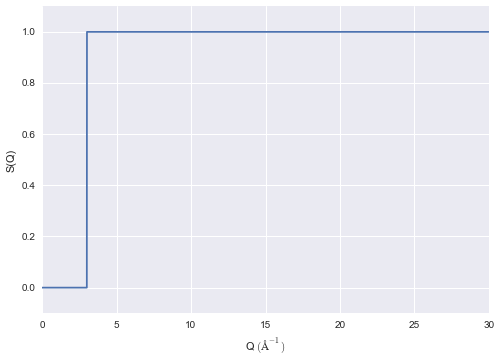

In [2]:
x = np.arange(0,30, 0.01)
y = np.ones(x.shape)
y[x<3]=0
plt.plot(x, y)
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('S(Q)')
plt.ylim(-0.1, 1.1)

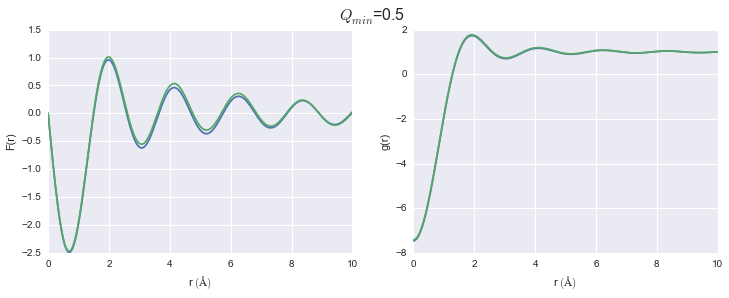

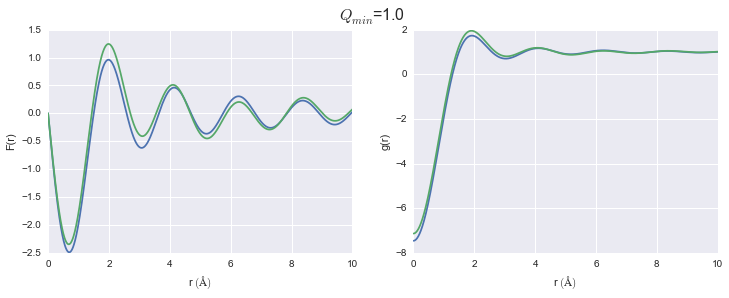

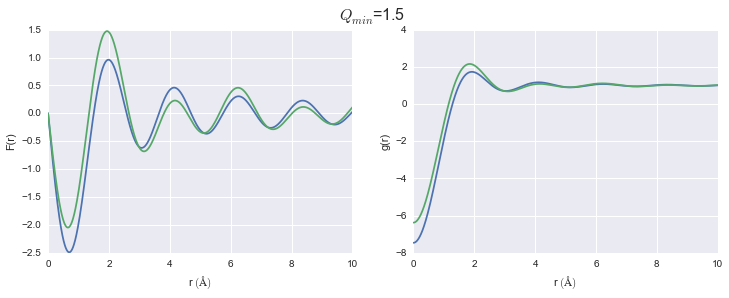

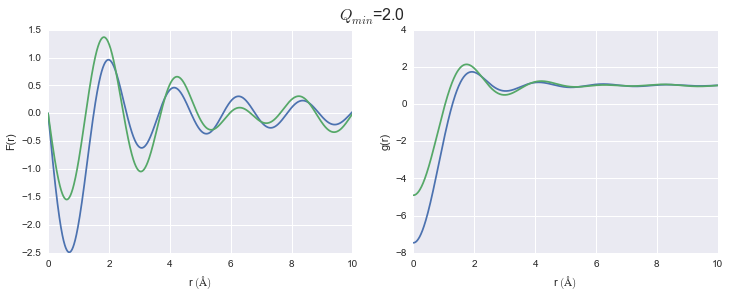

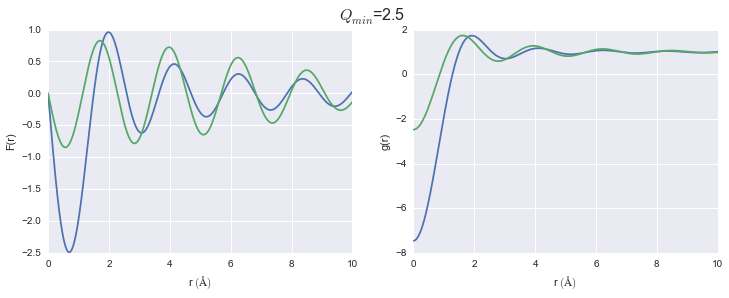

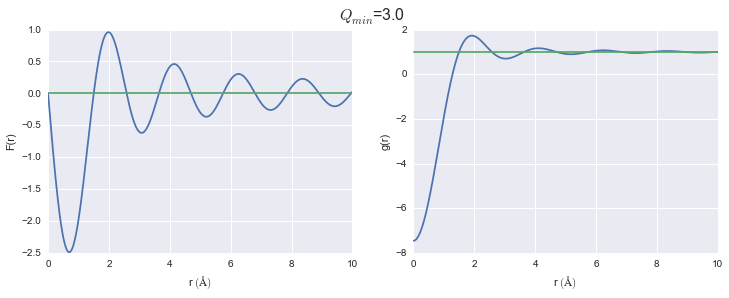

In [3]:
sq_simulated = Spectrum(x, y)
fr_simulated=calculate_fr(sq_simulated)
gr_simulated=calculate_gr(fr_simulated, 2.5, {'Si':1})

def plot_simulated(q_min):
    fr_simulated_m = calculate_fr(sq_simulated.limit(q_min, 30))
    gr_simulated_m = calculate_gr(fr_simulated_m, 2.5, {'Si':1})
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.suptitle("$Q_{{min}}$={}".format(q_min),size=16)
    plt.plot(*fr_simulated.data)
    plt.plot(*fr_simulated_m.data)
    plt.xlabel('r $(\AA)$')
    plt.ylabel('F(r)')
    
    plt.subplot(1,2,2)
    plt.plot(*gr_simulated.data)
    plt.plot(*gr_simulated_m.data)
    plt.xlabel('r $(\AA)$')
    plt.ylabel('g(r)')
 
q_min_list = np.arange(0.5, 3.5, 0.5)
for q_min in q_min_list:
    plot_simulated(q_min)

#2. Lets do the same with real data

We are going to load a data spectrum and background Spectrum of $Mg_2SiO_4$. The data is not optimal, it was intentionally not corrected for self absorption or oblique x-ray incidence on the detector. A way to try to correct for this is the optimization of the S(Q), which is described in Eggert et al. (2002). This is very useful for the data analysis of total scattering experiments from a sample e.g. loaded in a diamond anvil cell were the background might change with compression. In this kind of environment it is often very hard to know all the contributing background entities and further the background usually changes during compression.

##2.1 Extrapolation prior to Optimization
In the first example we will calculate S(Q) from the original data, then linearly extrapolate the spectrum to zero and afterwards optimize the S(Q) based on the method described in Eggert et al. (2002). After optimization the S(Q) is cut at different $Q_{min}$ in order to see the effect on the resulting F(r) and g(r). 

###2.1.1 Original data 

(0, 1.2)

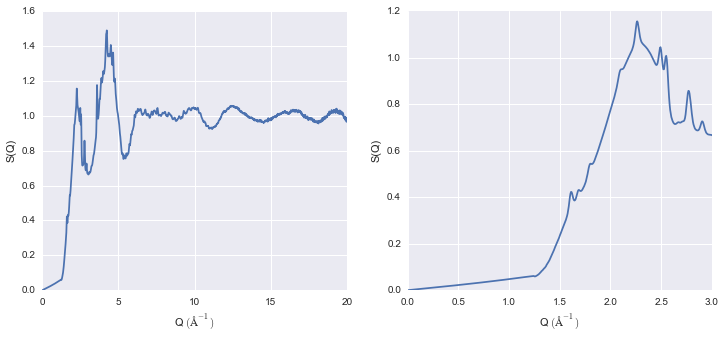

In [4]:
data_spectrum = Spectrum.from_file('../tests/data/Mg2SiO4_ambient.xy')
bkg_spectrum = Spectrum.from_file('../tests/data/Mg2SiO4_ambient_bkg.xy')
sample_spectrum = data_spectrum - bkg_spectrum

composition = {'Mg': 2, 'Si':1, 'O':4}
density = 2.9

sq = calculate_sq(sample_spectrum.limit(0, 20), density, composition)
sq1 = extrapolate_to_zero_linear(sq)
sq1_opt = optimize_sq(sq1, 1.5, 50, 0.088)

plt.figure(figsize=(12, 5))
plt.subplot(1,2, 1)
plt.plot(*sq1_opt.data)
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('S(Q)')
plt.subplot(1,2,2)
plt.plot(*sq1_opt.data)
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('S(Q)')
plt.xlim(0, 3)
plt.ylim(0, 1.2)

###2.1.2 Effect to F(r) and g(r)

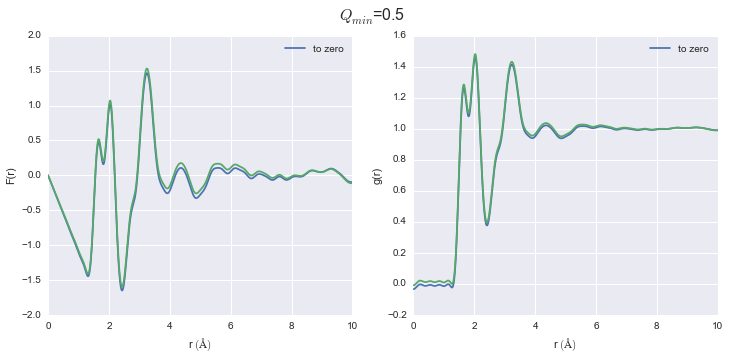

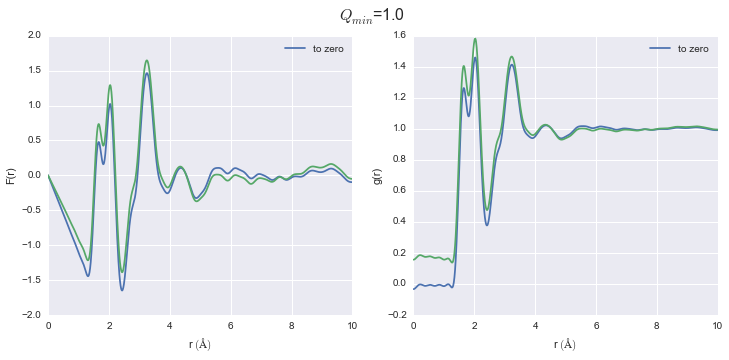

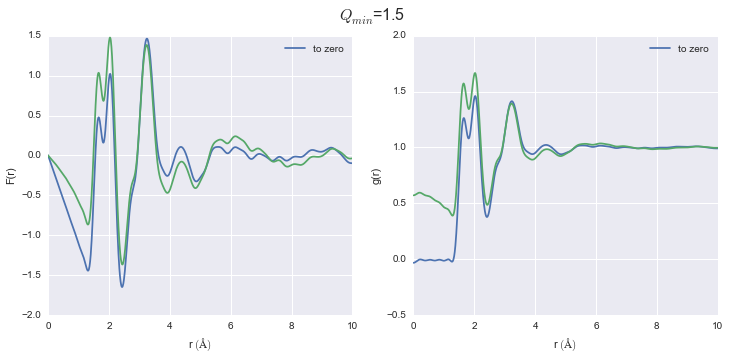

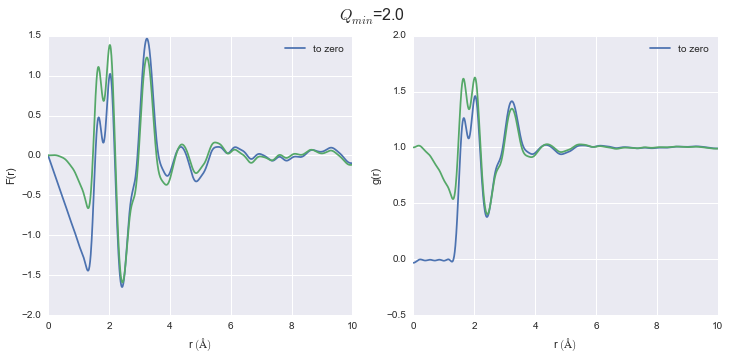

In [5]:
fr1 = calculate_fr(sq1_opt, use_modification_fcn=True)
gr1 = calculate_gr(fr1, density, composition)

def plot_all1(q_min):
    fr1_m = calculate_fr(sq1_opt.limit(q_min, 40), use_modification_fcn=True)
    gr1_m = calculate_gr(fr1_m, density, composition)
    
    plt.figure(figsize=(12,5))
    plt.suptitle("$Q_{{min}}$={}".format(q_min),size=16)
    plt.subplot(1,2,1)
    plt.plot(*fr1.data, label='to zero')
    plt.plot(*fr1_m.data)
    plt.xlabel('r $(\AA)$')
    plt.ylabel('F(r)')
    plt.legend(loc='best')
    
    plt.subplot(1,2,2)
    plt.plot(*gr1.data, label='to zero')
    plt.plot(*gr1_m.data)
    plt.xlabel('r $(\AA)$')
    plt.ylabel('g(r)')
    plt.legend(loc='best')
    

q_min_list = np.arange(0.5, 2.5, 0.5)
for q_min in q_min_list:
    plot_all1(q_min)
    

This result was completely surprising to me. Changing the $Q_{min}$ after optimization has a hug effect on F(r) and g(r). In particular the region below the first peak in g(r) is totally wrong. Which is a result of the $Q_{min}$ having a huge effect on density, which can also easily seen by the slope change in the F(r). 

##2.2 Optimization prior to Extrapolation 

In this example we will optimize the example data and afterwards do the extrapolation to zero.  

###2.2.1 Original Data

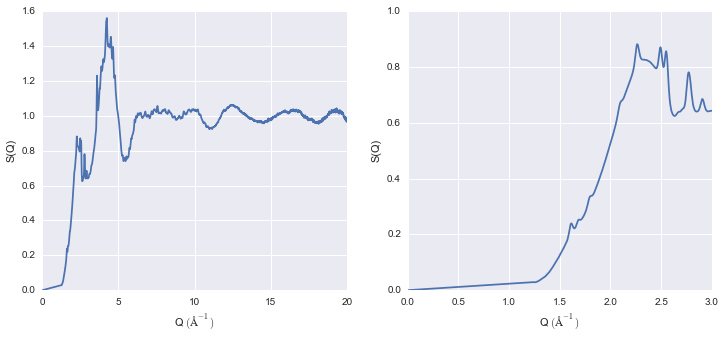

In [6]:
sq2 = calculate_sq(sample_spectrum.limit(0, 20), density, composition)
sq2 = optimize_sq(sq2, 1.5, 50, 0.088)
sq2 = extrapolate_to_zero_linear(sq2)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(*sq2.data)
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('S(Q)')
plt.subplot(1, 2, 2)
plt.plot(*sq2.data)
plt.xlim(0, 3)
plt.ylim(0, 1)
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('S(Q)')

###2.2.2 Changes in F(r) and g(r)

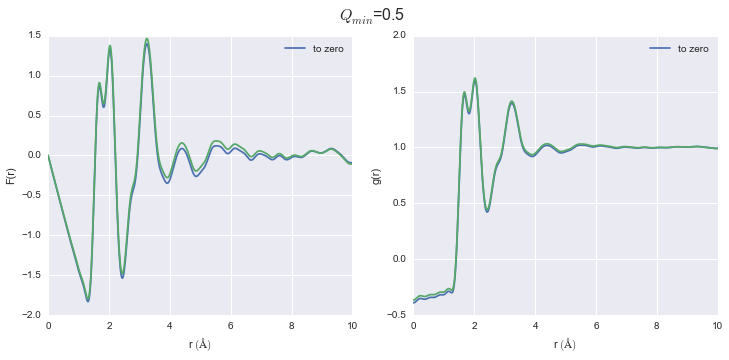

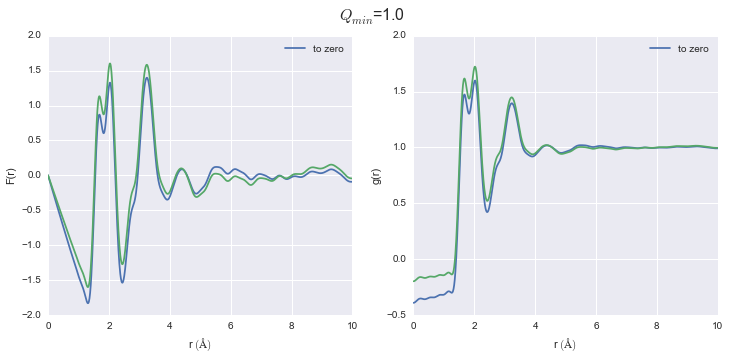

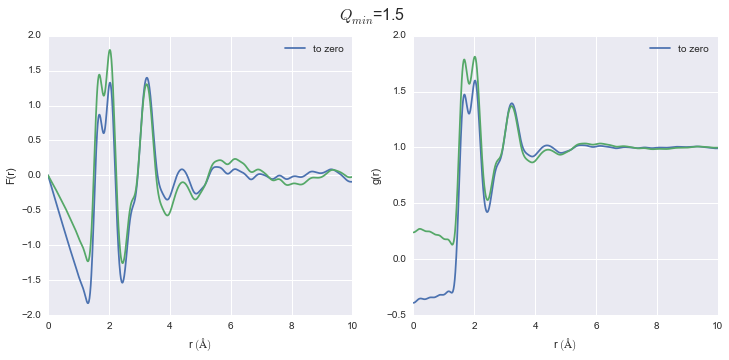

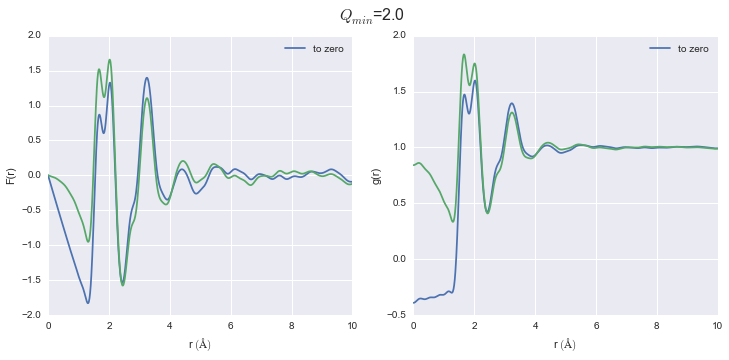

In [7]:
fr2 = calculate_fr(sq2, use_modification_fcn=True)
gr2 = calculate_gr(fr2, density, composition)

def plot_all2(q_min):
    fr2_m = calculate_fr(sq2.limit(q_min, 40), use_modification_fcn=True)
    gr2_m = calculate_gr(fr2_m, density, composition)
    
    plt.figure(figsize=(12,5))
    plt.suptitle("$Q_{{min}}$={}".format(q_min),size=16)
    plt.subplot(1,2,1)
    plt.plot(*fr2.data, label = "to zero")
    plt.plot(*fr2_m.data)
    plt.legend(loc='best')
    plt.xlabel('r $(\AA)$')
    plt.ylabel('F(r)')
    plt.subplot(1,2,2)
    
    plt.plot(*gr2.data, label = "to zero")
    plt.plot(*gr2_m.data)
    plt.legend(loc='best')
    plt.xlabel('r $(\AA)$')
    plt.ylabel('g(r)')
    
    

q_min_list = np.arange(0.5, 2.5, 0.5)
for q_min in q_min_list:
    plot_all2(q_min)
    

Another surprising result. We see again an odd behavior in the region below the first peak. This time the S(Q) extrapolated to zero is already off. One can sense that only a $Q_{min}$ between 1.0 and 1.5 has a correct shape of the g(r), which is exactly where the $Q_{min}$ of the non-extrapolated S(Q) lies. This shows that the optimization process basically locks a specific density into the g(r) but by afterwards changing $Q_{min}$ we get erronous results since $Q_{min}$ has a strong effect on the resulting density in F(r) (defined by initial slope).

##2.3 Cutting the original data at different minimum q

The above examples have shown that a change in minimum Q used has a strong effect on density (initial slope in f(r)) and on intensities in g(r) (resulting in different coordination numbers).

Another issue which can be explored is cutting the original sample data at different Q$_{min}$ values, then extrapolating to zero and do the optimization and see the effect on the resulting F(r) and g(r). This is very applicable to normal data collections, due to different sizes in beam stops the Q$_{min}$ for each beamline, data collection, or used energy might be different. This might also be the most meaningful way in order get reproducible data.

###2.3.1 Using linear Extrapolation

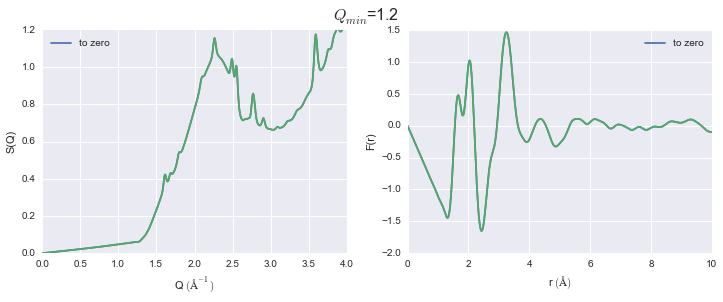

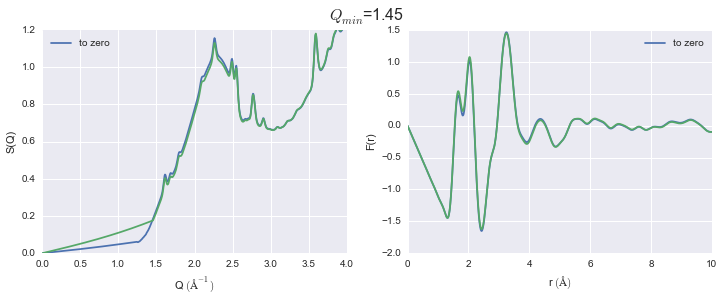

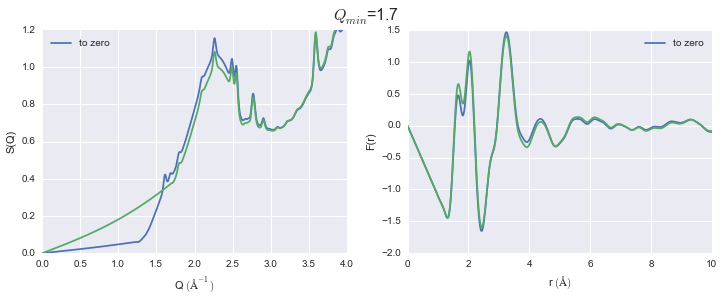

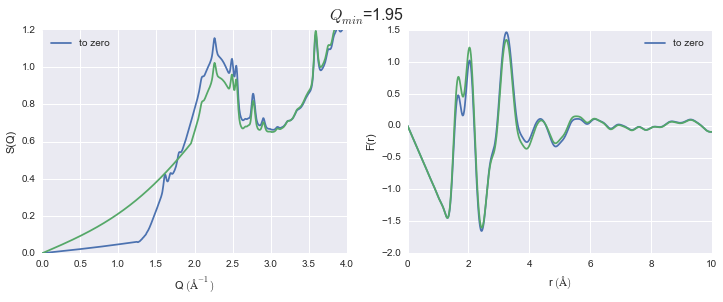

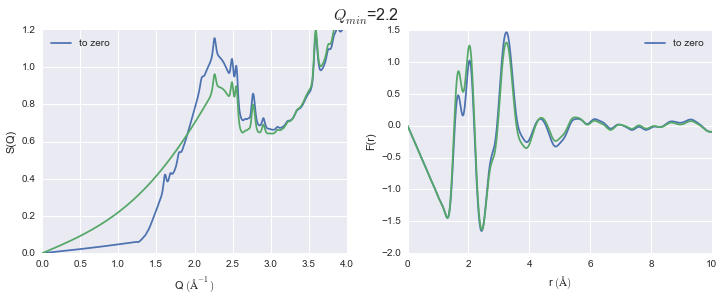

In [8]:
sq3 = calculate_sq(sample_spectrum.limit(0, 20), density, composition)
sq3_extrapolated = extrapolate_to_zero_linear(sq3)
sq3_opt = optimize_sq(sq3_extrapolated, 1.5, 50, 0.088)

fr3 = calculate_fr(sq3_opt, use_modification_fcn=True)

def plot_all3(q_min):
    sq3_m = calculate_sq(sample_spectrum.limit(q_min, 20),density, composition)
    sq3_m_extrapolated = extrapolate_to_zero_linear(sq3_m)
    sq3_m_opt = optimize_sq(sq3_m_extrapolated, 1.5, 50, 0.088)
    fr3_m = calculate_fr(sq3_m_opt, use_modification_fcn=True)
    
    plt.figure(figsize=(12,4))
    plt.suptitle("$Q_{{min}}$={}".format(q_min),size=16)
    plt.subplot(1, 2, 1)
    plt.plot(*sq3_opt.data, label = "to zero")
    plt.plot(*sq3_m_opt.data)
    plt.xlim(0, 4)
    plt.ylim(0, 1.2)
    plt.legend(loc='best')
    plt.xlabel('Q $(\AA^{-1})$')
    plt.ylabel('S(Q)')
    plt.subplot(1, 2, 2)
    plt.plot(*fr3.data, label = "to zero")
    plt.plot(*fr3_m.data)
    plt.legend(loc='best')
    plt.xlabel('r $(\AA)$')
    plt.ylabel('F(r)')
    
    
q_min_list = np.arange(1.2, 2.4, 0.25)
for q_min in q_min_list:
    plot_all3(q_min)

From the above pictures it can be seen that a too high $Q_{min}$ results in strongly changes FSDP after optimization and therefore also the resutling F(r) has changed peak intensities. However, densities (slop of g(r)) seems to be not effected...  

###2.3.2 Using polynomial extrapolation 

Another way to extrapolate the S(Q) data to zero would be to use the polynomial extension of the form:

$a(x-c)+b(x-c)^2$

whereby $a,b>0$, $c$ defines the intercept with $S(Q)=0$ and everything below $c$ will be set to zero.

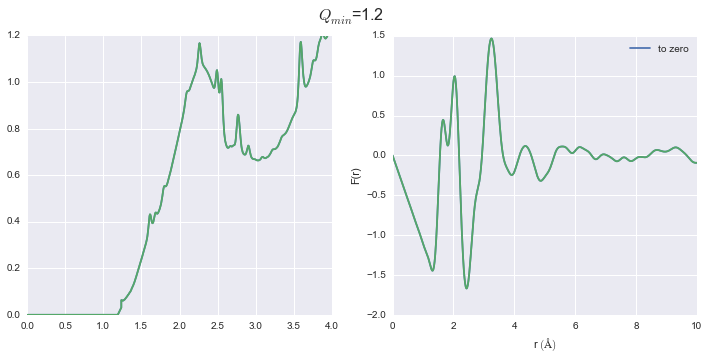

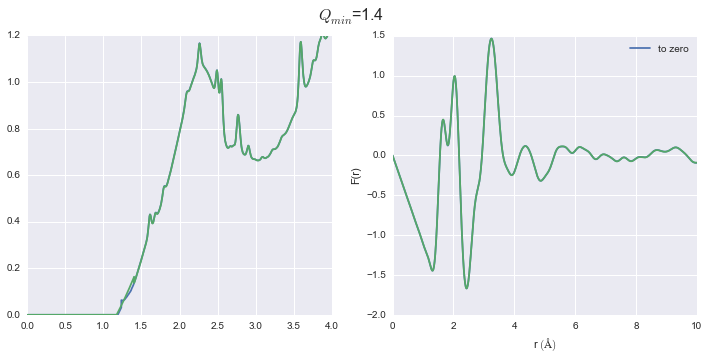

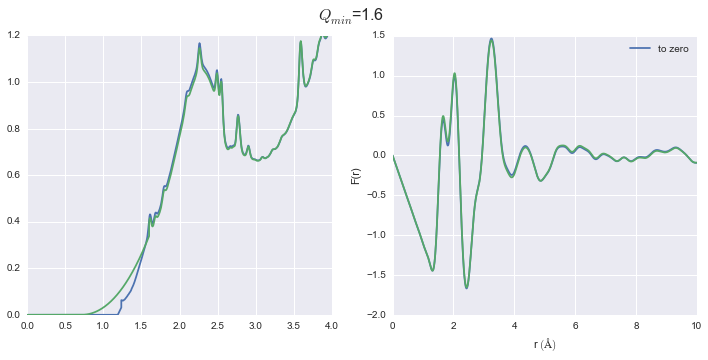

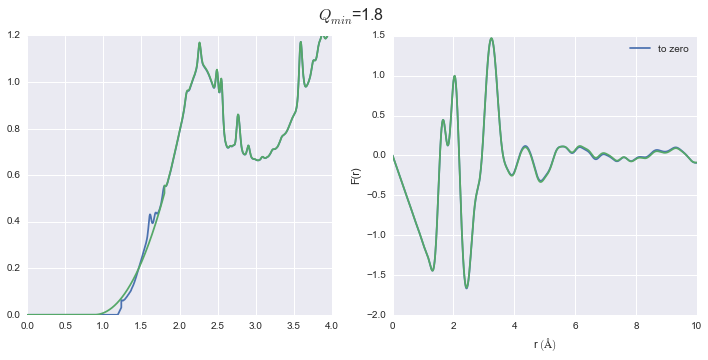

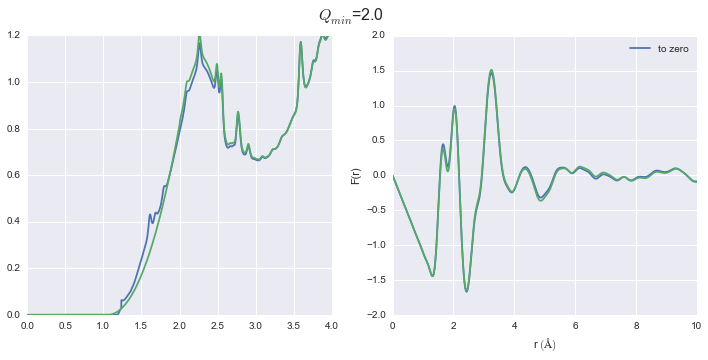

In [9]:
sq4 = calculate_sq(sample_spectrum.limit(0, 20), density, composition)
sq4_extrapolated = extrapolate_to_zero_poly(sq4, 2.1)
sq4_opt = optimize_sq(sq4_extrapolated, 1.5, 50, 0.088)

fr4 = calculate_fr(sq4_opt, use_modification_fcn=True)

def plot_all4(q_min):
    sq4_m = calculate_sq(sample_spectrum.limit(q_min, 20),density, composition)
    sq4_m_extrapolated = extrapolate_to_zero_poly(sq4_m, 2.1)
    sq4_m_opt = optimize_sq(sq4_m_extrapolated, 1.5, 50, 0.088)
    fr4_m = calculate_fr(sq4_m_opt, use_modification_fcn=True)
    
    plt.figure(figsize=(12,5))
    plt.suptitle("$Q_{{min}}$={}".format(q_min),size=16)
    plt.subplot(1,2,1)
    plt.plot(*sq4_opt.data)
    plt.plot(*sq4_m_opt.data)
    plt.xlim(0, 4)
    plt.ylim(0, 1.2)
    plt.subplot(1,2,2)
    plt.plot(*fr4.data, label = "to zero")
    plt.plot(*fr4_m.data)
    plt.legend(loc='best')
    plt.xlabel('r $(\AA)$')
    plt.ylabel('F(r)')
    
    
q_min_list = np.arange(1.2, 2.1, 0.2)
for q_min in q_min_list:
    plot_all4(q_min)

It can be easily seen that by using a polynomial extrapolation prior to optimization the $Q_{min}$ value has a very small effect on the resulting F(r). Which means that this is a very robust data analysis method even when the original data is cutting into the first sharp diffraction peak due to a for example too large beam stop or very high energy diffraction 

### 2.3.2 Set S(Q) to zero below Q$_{min}$

Some publication do not extrapolate the data to by using a functional form but set everything below the lowest minimum q collected to 0.

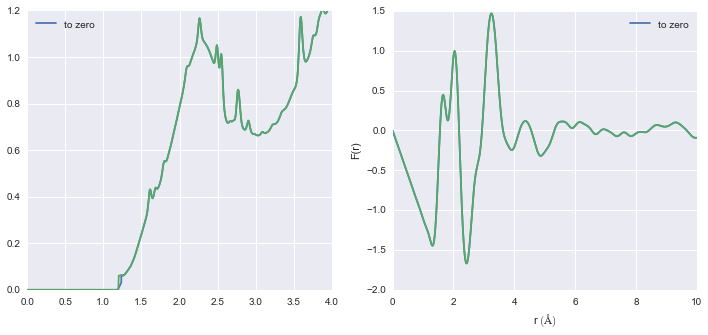

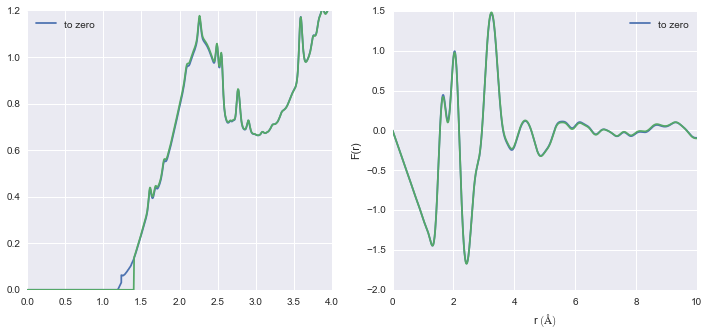

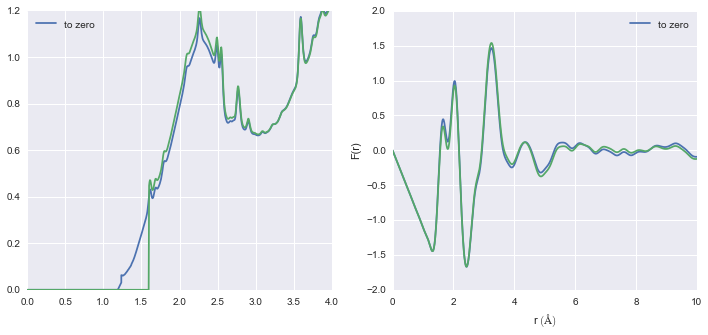

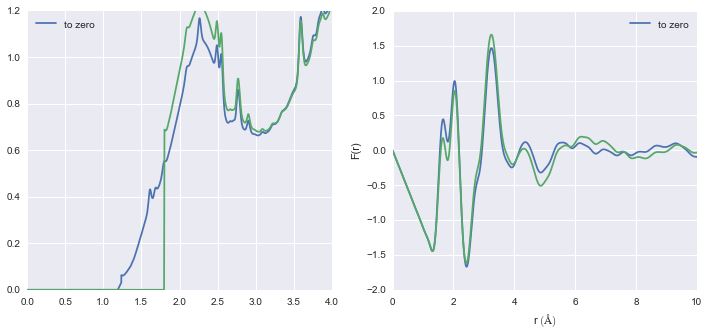

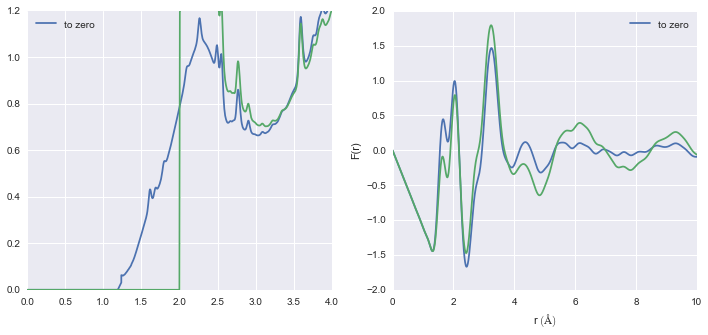

In [10]:
sq5 = calculate_sq(sample_spectrum.limit(0, 20), density, composition)
sq5_extrapolated = extrapolate_to_zero_poly(sq5, 2.1)
sq5_opt = optimize_sq(sq5_extrapolated, 1.5, 50, 0.088)

fr5 = calculate_fr(sq5_opt, use_modification_fcn=True)

def plot_all5(q_min):
    sq5_m = calculate_sq(sample_spectrum.limit(q_min, 20),density, composition)
    sq5_m_extrapolated = extrapolate_to_zero_linear(sq5_m)
    
    x, y = sq5_m_extrapolated.data
    y[x<=q_min]=0
    sq5_m_extrapolated = Spectrum(x, y)
    
    sq5_m_opt = optimize_sq(sq5_m_extrapolated, 1.5, 50, 0.088)
    fr5_m = calculate_fr(sq5_m_opt, use_modification_fcn=True)
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(*sq5_opt.data, label="to zero")
    plt.plot(*sq5_m_opt.data)
    plt.xlim(0, 4)
    plt.ylim(0, 1.2)
    plt.legend(loc='best')
    plt.subplot(1,2,2)
    plt.plot(*fr5.data, label = "to zero")
    plt.plot(*fr5_m.data)
    plt.legend(loc='best')
    plt.xlabel('r $(\AA)$')
    plt.ylabel('F(r)')
    
    
q_min_list = np.arange(1.2, 2.1, 0.2)
for q_min in q_min_list:
    plot_all5(q_min)

It can be easily seen that when the first sharp diffraction peak (FSDP) is cutted at too large q values the optimization method artificially increases the instensity of the FSDP and thus also the resulting F(r) Intensities are completely differnt. This method seems to only work when the FSDP is almost completely present in the original data. 

#3. Conclusion

Based on the above exploration of all the possibilities for using extrapolation in combinization with optimization I came to the following conclusions

  - Extrapolation to zero should be always used since otherwise the density shown in the initial slope of the F(r) is different
  - Extrapolation of the data to zero should be done prior to optimization (see section 2.1/2.2)
  - the polynomial extrapolation has the smallest effect on the resulting F(r) and g(r)
 
  

